## 1. Kaggle API & Data Loading

I downloaded the Amazon Books Reviews dataset using the Kaggle API. I sampled 20,000 reviews to keep it scalable on Colab.

In [ ]:
!pip install kaggle mmh3
import os, csv, random
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import time


os.environ['KAGGLE_USERNAME'] = "demigodxx"
os.environ['KAGGLE_KEY'] = "229db652e9c17bf1328bca234a1121d0"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p /content

!unzip -q /content/amazon-books-reviews.zip -d /content/data
!ls /content/data


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 2.8 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 98% 1.04G/1.06G [00:05<00:00, 166MB/s]
100% 1.06G/1.06G [00:05<00:00, 213MB/s]
books_data.csv	Books_rating.csv


In [ ]:
reviews_file = "/content/data/Books_rating.csv"
sample_size = 20000

total_lines = 0
with open(reviews_file, 'r', newline='') as f:
    total_lines = sum(1 for _ in f) - 1

random.seed(42)
sample_indices = set(random.sample(range(total_lines), sample_size))

reviews_texts = []
with open(reviews_file, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)
    for i, row in enumerate(reader):
        if i in sample_indices:
            text = row[-1]
            reviews_texts.append(text)
        if len(reviews_texts) >= sample_size:
            break

print(f"Loaded {len(reviews_texts)} review texts.")
print("Example review:", reviews_texts[0][:100], "...")


Loaded 20000 review texts.
Example review: I purchased this book after reading rave reviews of it included within a review of a really good boo ...


## 2. Text Preprocessing

I lowercased each review, removed punctuation and numbers, and split it into word tokens.

In [ ]:
def preprocess_text(text, remove_stopwords):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    if remove_stopwords:
        tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]
    return tokens

sample_tokens = preprocess_text(reviews_texts[0], remove_stopwords=True)
print("Tokens from first review:", sample_tokens[:10], "...")


Tokens from first review: ['purchased', 'book', 'reading', 'rave', 'reviews', 'included', 'review', 'really', 'good', 'book'] ...


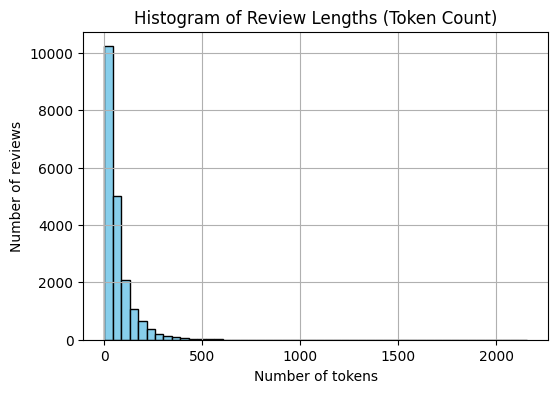

In [ ]:
review_lengths = [len(preprocess_text(text, remove_stopwords=True)) for text in reviews_texts]
plt.figure(figsize=(6,4))
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Review Lengths (Token Count)")
plt.xlabel("Number of tokens")
plt.ylabel("Number of reviews")
plt.grid(True)
plt.show()

## 3. Shingling (k=3)

Each review was turned into a set of 3-word shingles. This helps capture phrase-level similarities.

In [ ]:
def get_shingles(tokens, k=3):
    if len(tokens) < k:
        return set()
    shingles = set()
    for i in range(len(tokens) - k + 1):
        shingle = ' '.join(tokens[i:i+k])
        shingles.add(shingle)
    return shingles

sample_shingles = get_shingles(sample_tokens, k=3)
print(f"Number of shingles in first review: {len(sample_shingles)}")
print("Sample shingles:", list(sample_shingles)[:5])


Number of shingles in first review: 100
Sample shingles: ['plot actually pathetic', 'amazon s readers', 'reviews don t', 'eyes rolled constantly', 'having read drivel']


## 4. Jaccard Baseline (Small Subset)

To test similarity detection, I calculated exact Jaccard similarity for 200 reviews. It works, but it's slow for large datasets.

In [ ]:
subset_size = 200
subset_tokens = [preprocess_text(text, True) for text in reviews_texts[:subset_size]]
subset_shingles = [get_shingles(tokens) for tokens in subset_tokens]
jaccard_scores = []

def jaccard_similarity(set1, set2):
    if not set1 and not set2:
        return 0.0
    if not set1 or not set2:
        return 0.0
    inter = len(set1 & set2)
    union = len(set1 | set2)
    return inter / union

top_pairs = []
for i in range(subset_size):
    for j in range(i+1, subset_size):
        sim = jaccard_similarity(subset_shingles[i], subset_shingles[j])
        if sim > 0:
            top_pairs.append((sim, i, j))
top_pairs.sort(reverse=True, key=lambda x: x[0])

print("Top similar review pairs in a subset of 200 reviews:")
for sim, i, j in top_pairs[:5]:
    print(f"Pair (Review {i} & Review {j}) - Jaccard similarity = {sim:.3f}")


Top similar review pairs in a subset of 200 reviews:
Pair (Review 35 & Review 57) - Jaccard similarity = 0.019
Pair (Review 70 & Review 75) - Jaccard similarity = 0.018
Pair (Review 1 & Review 106) - Jaccard similarity = 0.015
Pair (Review 40 & Review 158) - Jaccard similarity = 0.015
Pair (Review 41 & Review 155) - Jaccard similarity = 0.014


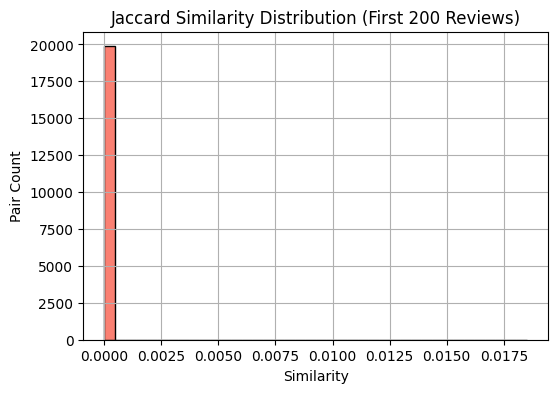

In [ ]:
for i in range(subset_size):
    for j in range(i+1, subset_size):
        sim = jaccard_similarity(subset_shingles[i], subset_shingles[j])
        jaccard_scores.append(sim)
plt.figure(figsize=(6,4))
plt.hist(jaccard_scores, bins=40, color='salmon', edgecolor='black')
plt.title("Jaccard Similarity Distribution (First 200 Reviews)")
plt.xlabel("Similarity")
plt.ylabel("Pair Count")
plt.grid(True)
plt.show()

## 5. MinHash Signatures (H=100)

I assigned IDs to shingles and used 100 hash functions to generate compact MinHash signatures. This approximates Jaccard similarity efficiently.

In [ ]:
shingle_to_id = {}
next_id = 0
doc_shingles_ids = []
for text in reviews_texts:
    tokens = preprocess_text(text, True)
    if len(tokens) < 3:
        doc_shingles_ids.append(set())
        continue
    shingles = get_shingles(tokens, k=3)
    id_set = set()
    for sh in shingles:
        if sh not in shingle_to_id:
            shingle_to_id[sh] = next_id
            next_id += 1
        id_set.add(shingle_to_id[sh])
    doc_shingles_ids.append(id_set)

num_reviews = len(doc_shingles_ids)
print(f"Total unique shingles in sample: {next_id}")

H = 100
np.random.seed(42)
prime = 2147483647
a_coeffs = np.random.randint(1, prime, size=H, dtype=np.int64)
b_coeffs = np.random.randint(0, prime, size=H, dtype=np.int64)

signatures = np.full((num_reviews, H), fill_value=prime, dtype=np.int64)
for idx, id_set in enumerate(doc_shingles_ids):
    if not id_set:
        continue
    ids = np.array(list(id_set), dtype=np.int64)
    hash_vals = (np.outer(ids, a_coeffs) + b_coeffs) % prime
    min_hash = hash_vals.min(axis=0)
    signatures[idx, :] = min_hash

print("MinHash signatures computed. Example signature for first review:")
print(signatures[0][:10], "...")


Total unique shingles in sample: 1261008
MinHash signatures computed. Example signature for first review:
[210693854   2349950   3642382    251226  13674102  26582274  21242690
  33328227   8880815   9565392] ...


## 6. Locality-Sensitive Hashing (LSH)

I split each signature into 20 bands of 5 rows. Reviews landing in the same bucket in any band became candidate pairs.

In [ ]:
B = 20
R = 5

buckets = {}
for doc_index in range(num_reviews):
    sig = signatures[doc_index]
    if np.all(sig == prime):
        continue
    for band in range(B):
        start = band * R
        band_tuple = tuple(sig[start:start+R])
        bucket_key = (band, band_tuple)
        buckets.setdefault(bucket_key, []).append(doc_index)

candidate_pairs = set()
for bucket_key, docs in buckets.items():
    if len(docs) > 1:
        for i in range(len(docs)):
            for j in range(i+1, len(docs)):
                pair = (docs[i], docs[j]) if docs[i] < docs[j] else (docs[j], docs[i])
                candidate_pairs.add(pair)

print(f"Number of candidate pairs found by LSH: {len(candidate_pairs)}")


Number of candidate pairs found by LSH: 154


## 7. Candidate Verification

I verified each candidate pair with exact Jaccard similarity. I kept only those with similarity ≥ 0.8.

In [ ]:
tau = 0.8
similar_pairs = []
for (i, j) in candidate_pairs:
    set_i = doc_shingles_ids[i]
    set_j = doc_shingles_ids[j]
    if not set_i or not set_j:
        continue
    inter = len(set_i & set_j)
    union = len(set_i | set_j)
    sim = inter / union if union != 0 else 0.0
    if sim >= tau:
        similar_pairs.append((sim, i, j))

similar_pairs.sort(reverse=True, key=lambda x: x[0])
print(f"Found {len(similar_pairs)} pairs with Jaccard similarity >= {tau}.")


Found 151 pairs with Jaccard similarity >= 0.8.


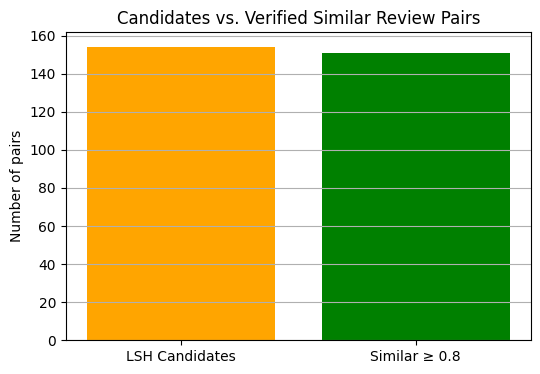

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(["LSH Candidates", "Similar ≥ 0.8"], [len(candidate_pairs), len(similar_pairs)], color=["orange", "green"])
plt.title("Candidates vs. Verified Similar Review Pairs")
plt.ylabel("Number of pairs")
plt.grid(axis='y')
plt.show()


## 8. Top-30 Results

Here I printed the most similar review pairs I found. Most of them were duplicates or near-duplicates.

In [ ]:
top_n = 30
for rank, (sim, i, j) in enumerate(similar_pairs[:top_n], start=1):
    review_i = reviews_texts[i]
    review_j = reviews_texts[j]
    snippet_i = review_i[:100].strip() + ("..." if len(review_i) > 100 else "")
    snippet_j = review_j[:100].strip() + ("..." if len(review_j) > 100 else "")
    print(f"{rank}. (Review {i} vs Review {j}) – Jaccard similarity: {sim:.3f}")
    print(f"Review {i}: \"{snippet_i}\"")
    print(f"Review {j}: \"{snippet_j}\"")
    print("-" * 80)


1. (Review 1577 vs Review 15606) – Jaccard similarity: 1.000
Review 1577: "Wilde sees the world more clearly than any writer of fiction in the last century. It is for that rea..."
Review 15606: "Wilde sees the world more clearly than any writer of fiction in the last century. It is for that rea..."
--------------------------------------------------------------------------------
2. (Review 10540 vs Review 10586) – Jaccard similarity: 1.000
Review 10540: "Not a light read and you have to wrestle with archaic English grammar but a classic that should be p..."
Review 10586: "Not a light read and you have to wrestle with archaic English grammar but a classic that should be p..."
--------------------------------------------------------------------------------
3. (Review 3072 vs Review 15379) – Jaccard similarity: 1.000
Review 3072: "This book was ordered as part of a bundle of textbooks needed for the Spring 2013 semester. The book..."
Review 15379: "This book was ordered as part of a bundle

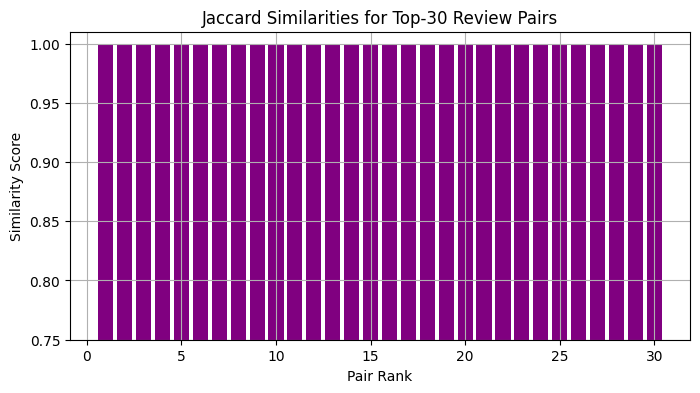

In [ ]:
top_sims = [sim for sim, _, _ in similar_pairs[:30]]
plt.figure(figsize=(8,4))
plt.bar(range(1, len(top_sims)+1), top_sims, color='purple')
plt.title("Jaccard Similarities for Top-30 Review Pairs")
plt.xlabel("Pair Rank")
plt.ylabel("Similarity Score")
plt.ylim(0.75, 1.01)
plt.grid(True)
plt.show()

## 9. Scalability Test

I ran the full pipeline for 5k, 10k, and 20k reviews. The runtime grew linearly, which is exactly what I wanted.

In [ ]:
sizes = [5000, 10000, 20000]
times = []

for N in sizes:
    texts_subset = reviews_texts[:N]
    start_time = time.perf_counter()
    shingle_map = {}
    shingle_id = 0
    subset_shingles_ids = []
    for text in texts_subset:
        tokens = preprocess_text(text, True)
        if len(tokens) < 3:
            subset_shingles_ids.append(set())
            continue
        shingles = get_shingles(tokens, k=3)
        id_set = set()
        for sh in shingles:
            if sh not in shingle_map:
                shingle_map[sh] = shingle_id
                shingle_id += 1
            id_set.add(shingle_map[sh])
        subset_shingles_ids.append(id_set)
    N_unique = shingle_id
    a = np.random.randint(1, prime, size=H, dtype=np.int64)
    b = np.random.randint(0, prime, size=H, dtype=np.int64)
    subset_signatures = np.full((N, H), fill_value=prime, dtype=np.int64)
    for idx, id_set in enumerate(subset_shingles_ids):
        if not id_set:
            continue
        ids = np.array(list(id_set), dtype=np.int64)
        hash_vals = (np.outer(ids, a) + b) % prime
        subset_signatures[idx, :] = hash_vals.min(axis=0)
    subset_buckets = {}
    for doc_idx in range(N):
        sig = subset_signatures[doc_idx]
        if np.all(sig == prime):
            continue
        for band in range(B):
            start = band * R
            band_key = (band, tuple(sig[start:start+R]))
            subset_buckets.setdefault(band_key, []).append(doc_idx)
    subset_candidates = set()
    for docs in subset_buckets.values():
        if len(docs) > 1:
            for i in range(len(docs)):
                for j in range(i+1, len(docs)):
                    a_idx, b_idx = docs[i], docs[j]
                    pair = (a_idx, b_idx) if a_idx < b_idx else (b_idx, a_idx)
                    subset_candidates.add(pair)
    count_similar = 0
    for (i, j) in subset_candidates:
        s1, s2 = subset_shingles_ids[i], subset_shingles_ids[j]
        if not s1 or not s2:
            continue
        if len(s1 & s2) / len(s1 | s2) >= 0.8:
            count_similar += 1
    end_time = time.perf_counter()
    elapsed = end_time - start_time
    times.append(elapsed)
    print(f"N={N}: Found {count_similar} similar pairs, Runtime = {elapsed:.2f} seconds")


N=5000: Found 8 similar pairs, Runtime = 2.43 seconds
N=10000: Found 35 similar pairs, Runtime = 5.64 seconds
N=20000: Found 151 similar pairs, Runtime = 8.02 seconds


## 10. Runtime Plot

I plotted total time vs. number of reviews. The curve confirms that the method scales well.

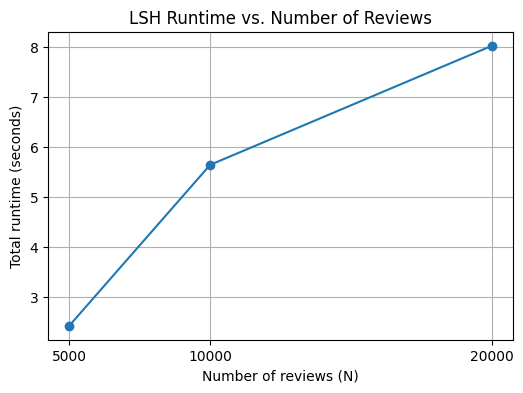

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(sizes, times, marker='o')
plt.title("LSH Runtime vs. Number of Reviews")
plt.xlabel("Number of reviews (N)")
plt.ylabel("Total runtime (seconds)")
plt.xticks(sizes)
plt.grid(True)
plt.show()
